In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-hold-power-data/household_power_consumption.txt


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/kaggle/input/house-hold-power-data/household_power_consumption.txt',sep=';',parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True,na_values=['nan','?'])

In [4]:
data.head()

,date_time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
#shape of data
data.shape

(2075259, 8)

In [6]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### Active Power: The is the consumable power for devices. It powers the electric ciruits or loads in an environment. If the voltage is not high enough the active power can not be supplied.It is measured in KW or MW.

### Reactive Power: Reactive power is used to provide the voltage levels necessary for active power to do useful work.Reactive power is essential to move active power through the transmission and distribution system to the customer. It is measured in KVAR or MVAR


In [7]:
# checking for duplicates
duplicate_sum =data.duplicated().sum()
print(duplicate_sum)

0


In [8]:
# checking for null cells
null_cells = data.isnull().sum()
print(null_cells)

date_time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [9]:
# Filling up the null cells
for i in range(1,8):
    data.iloc[:,i]=data.iloc[:,i].fillna(data.iloc[:,i].value_counts().index[0])    

In [10]:
# confirmation of filled null cells
null_cells = data.isnull().sum()
print(null_cells)

date_time                0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


### Using LSTMS to predict the trend.

In [11]:
data = data[['date_time','Global_active_power','Global_reactive_power', 'Voltage']]

In [12]:
data = data.set_index('date_time')

In [13]:
data.head()

,Global_active_power,Global_reactive_power,Voltage
date_time,,,
2006-12-16 17:24:00,4.216,0.418,234.84
2006-12-16 17:25:00,5.360,0.436,233.63
2006-12-16 17:26:00,5.374,0.498,233.29
2006-12-16 17:27:00,5.388,0.502,233.74
2006-12-16 17:28:00,3.666,0.528,235.68


In [14]:
len(data)

2075259

In [15]:
train = data[:2075000]
test = data[2075000:]

In [16]:
from sklearn.preprocessing import MinMaxScaler
sc =MinMaxScaler(feature_range = (0,1))
scaled_data = sc.fit_transform(train)

In [17]:
top = len(scaled_data)
print(top)

2075000


In [18]:
time_steps = 30

In [19]:
# creating the time steps
x_train = []
y_train = []

for i in range(time_steps, top):
    x_train.append(scaled_data[i-time_steps:i, :])  
    y_train.append(scaled_data[i,:])

In [20]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [21]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 3)) # 3 is the no. 0f coloumns, x_train.shape[0] is the rows,
                                                                      # x_train.shape[1] is the timesteps

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [23]:
trend_detector = Sequential()

In [24]:
trend_detector.add(LSTM(units = 30, return_sequences = True, input_shape = (x_train.shape[1], 3)))
trend_detector.add(Dropout(0.3))
trend_detector.add(LSTM(units = 30, return_sequences =True))
trend_detector.add(Dropout(0.3))
trend_detector.add(LSTM(units = 30))
trend_detector.add(Dropout(0.3))
trend_detector.add(Dense(units=3))
trend_detector.compile(optimizer = 'RMSprop', loss = 'mean_squared_error', metrics = ['accuracy'])

In [25]:
trend_detector.fit(x_train, y_train, epochs = 3, batch_size = 10)

Epoch 1/3
207497/207497 [==============================] - 1728s 8ms/step - loss: 0.0011 - accuracy: 0.9884
Epoch 2/3
207497/207497 [==============================] - 1656s 8ms/step - loss: 0.0010 - accuracy: 0.9888
Epoch 3/3
207497/207497 [==============================] - 1695s 8ms/step - loss: 0.0010 - accuracy: 0.9888


In [40]:
from keras.models import Model
# saving the model
trend_detector.save('trend_detector_model0.h5')

In [27]:
total = pd.concat((train, test), axis = 0)

In [28]:
new_data = total[len(total) - len(test) - time_steps :]

In [29]:
new_data = sc.transform(new_data)

In [30]:
test_count = len(test)

In [31]:
val = time_steps + test_count

In [32]:
x_test = []
for i in range(time_steps, val): 
    x_test.append(new_data[i - time_steps: i, : ])

In [33]:
x_test= np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 3))

In [35]:
predicted_values_calc = trend_detector.predict(x_test)
predicted_values = sc.inverse_transform(predicted_values_calc)

In [36]:
pred_df = pd.DataFrame(predicted_values, columns= data.columns)

In [37]:

pred_df.head()

,Global_active_power,Global_reactive_power,Voltage
0,1.120643,0.258840,241.073303
1,1.103513,0.261382,241.377258
2,1.127715,0.254799,240.791718
3,1.135795,0.199272,240.726883
4,1.079169,0.102521,240.754196


In [42]:
test.head()

,Global_active_power,Global_reactive_power,Voltage
date_time,,,
2010-11-26 16:44:00,1.086,0.272,241.08
2010-11-26 16:45:00,1.082,0.270,240.53
2010-11-26 16:46:00,1.104,0.232,240.37
2010-11-26 16:47:00,1.084,0.146,240.40
2010-11-26 16:48:00,1.884,0.336,239.11


In [43]:
len(test)

259

In [44]:
len(pred_df)

259

In [45]:

hold = test.index.values

In [47]:
pred_df['date_time'] = hold

In [49]:
pred_df = pred_df.set_index('date_time')
pred_df.head()

,Global_active_power,Global_reactive_power,Voltage
date_time,,,
2010-11-26 16:44:00,1.120643,0.258840,241.073303
2010-11-26 16:45:00,1.103513,0.261382,241.377258
2010-11-26 16:46:00,1.127715,0.254799,240.791718
2010-11-26 16:47:00,1.135795,0.199272,240.726883
2010-11-26 16:48:00,1.079169,0.102521,240.754196


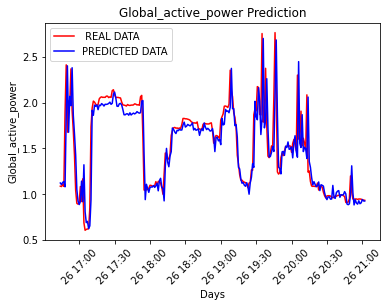

In [51]:
# Prediction for Global active power
plt.plot(test['Global_active_power'], color = 'red', label = ' REAL DATA')
plt.plot(pred_df['Global_active_power'], color = 'blue', label= 'PREDICTED DATA')
plt.title('Global_active_power Prediction')
plt.xlabel('Days')
plt.xticks(rotation=45)
plt.ylabel('Global_active_power')
plt.legend()
plt.show()

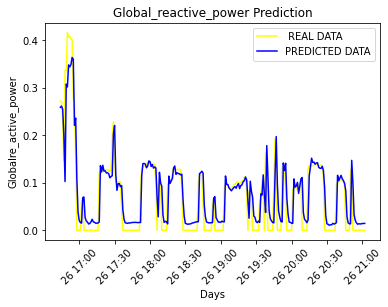

In [52]:
plt.plot(test['Global_reactive_power'], color = 'green', label = ' REAL DATA')
plt.plot(pred_df['Global_reactive_power'], color = 'blue', label= 'PREDICTED DATA')
plt.title('Global_reactive_power Prediction')
plt.xlabel('Days')
plt.xticks(rotation=45)
plt.ylabel('Globalre_active_power')
plt.legend()
plt.show()